In [23]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

import tensorflow as tf
%tensorflow_version 1.x
print(tf.__version__)




UsageError: Line magic function `%tensorflow_version` not found.


In [11]:

import os 
path = 'D:/Masters project/Git/Project_GAN-IDS/Data'
os.chdir(path)

df = pd.read_csv('iot23_full.csv', index_col=0)

C:\Users\camer\anaconda3\envs\py37gpu\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [15]:
min_max_scaler = MinMaxScaler().fit(df)
df_scaled = min_max_scaler.transform(df)


In [17]:
def build_generator(n_columns, latent_dim):
    model = Sequential()
    model.add(Dense(32, kernel_initializer = "he_uniform", input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(64,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(128,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(n_columns, activation = "sigmoid"))
    return model

In [25]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import scipy.stats

In [26]:
latent_dim = 50
from keras.models import Sequential, Model
generator = build_generator(df_scaled.shape[1], latent_dim)

In [30]:
optimizer = Adam(lr=0.0002, beta_1=0.5)

In [31]:
def build_discriminator(inputs_n):
    model = Sequential()
    model.add(Dense(128,  kernel_initializer = "he_uniform", input_dim = inputs_n))
    model.add(LeakyReLU(0.2))
    model.add(Dense(64,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(Dense(32,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(Dense(16,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

In [32]:
discriminator = build_discriminator(df_scaled.shape[1])

In [33]:
def build_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect generator and dicriminator
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss = "binary_crossentropy", optimizer = optimizer)
    return model

In [34]:
gan = build_gan(generator, discriminator)

In [35]:
def train(gan, generator, discriminator, data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)

    #lists for stats from the model
    generator_loss = []
    discriminator_loss = []

    #generate class labels for fake = 0 and real = 1
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    #training loop
    for i in range(n_epochs):
        
        #select random batch from the real numerical data
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]
        
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses
        d_loss_real, _ = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, _ = discriminator.train_on_batch(fake_data, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)

        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)
        generator_loss.append(g_loss)

        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Generator loss: %f] [Discriminator loss: %f]" % (i + 1, g_loss, d_loss))

    #plot losses after training
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.legend()
    plt.grid()

Epoch: 250 [Generator loss: 5.906230] [Discriminator loss: 0.243499]
Epoch: 500 [Generator loss: 3.374945] [Discriminator loss: 0.478908]
Epoch: 750 [Generator loss: 1.609812] [Discriminator loss: 0.635227]
Epoch: 1000 [Generator loss: 0.975289] [Discriminator loss: 0.662629]
Epoch: 1250 [Generator loss: 0.840901] [Discriminator loss: 0.669520]
Epoch: 1500 [Generator loss: 0.835461] [Discriminator loss: 0.685551]
Epoch: 1750 [Generator loss: 0.854737] [Discriminator loss: 0.669087]
Epoch: 2000 [Generator loss: 0.808300] [Discriminator loss: 0.669489]
Epoch: 2250 [Generator loss: 0.805268] [Discriminator loss: 0.683130]
Epoch: 2500 [Generator loss: 0.795856] [Discriminator loss: 0.676618]
Epoch: 2750 [Generator loss: 0.788410] [Discriminator loss: 0.702909]
Epoch: 3000 [Generator loss: 0.793286] [Discriminator loss: 0.678911]
Epoch: 3250 [Generator loss: 0.804905] [Discriminator loss: 0.679210]
Epoch: 3500 [Generator loss: 0.800229] [Discriminator loss: 0.685860]
Epoch: 3750 [Generator 

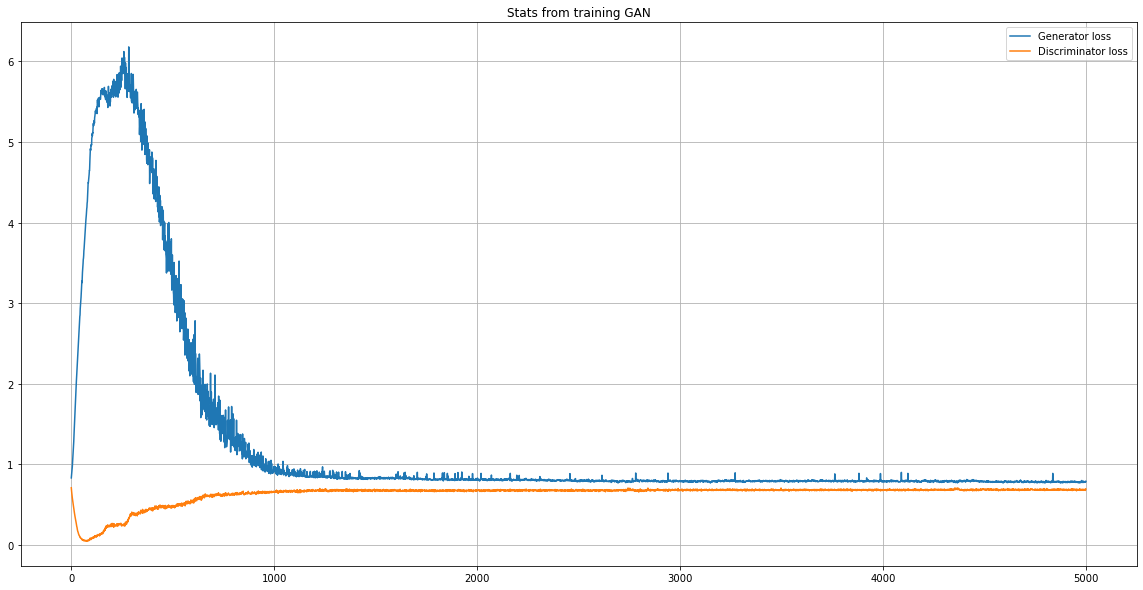

In [37]:
train(gan, generator, discriminator, df_scaled, latent_dim, n_epochs = 5000, n_batch = 1024, n_eval = 250)